# Loading Data

## Load Viewer/Chat/Twitter Data

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from __future__ import unicode_literals

plt.style.use('fivethirtyeight')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['xtick.color'] = 'grey'
plt.rcParams['ytick.color'] = 'grey'

with open('marathon_data/sgdq2016final.json') as f:
    raw_data = json.loads(f.read())
games = map(lambda x: raw_data['games'][x], raw_data['games'])
games.sort(lambda x, y: x['start_time'] - y['start_time'])

marathon_data = []
# Deep dictionary merge
for time_key in list(set(raw_data['data'].keys()).union(raw_data['extras'].keys())):
    payload = {}
    payload['time'] = int(time_key)
    if time_key in raw_data['data']:
        payload.update(raw_data['data'][time_key])
    if time_key in raw_data['extras']:
        payload.update(raw_data['extras'][time_key])
    for idx, i in enumerate(games):
        if int(i['start_time']) > int(payload['time']):
            payload['game'] = games[idx-1]['title'] if idx - 1 > 0 else np.nan
            break
    marathon_data.append(payload)
graph_df = pd.DataFrame(marathon_data)
graph_df['time'] = pd.to_datetime(graph_df['time'], unit='ms')
graph_df = graph_df.set_index('time').sort_index()
graph_df = graph_df.tz_localize('UTC').tz_convert('US/Central')
graph_df['cum_emotes'] = graph_df.e.cumsum()
graph_df['cum_chats']  = graph_df.c.cumsum()
graph_df['avg_don'] = graph_df.m / graph_df.d
graph_df['m_per_min'] = graph_df.m.diff()

## Load Bid Tracker Data

In [2]:
with open('marathon_data/killVsSave.json') as f:
    raw_bid_data = json.loads(f.read())
bid_data = []
kill_data = raw_bid_data['ys'][0][1:]
save_data = raw_bid_data['ys'][1][1:]

for idx, time in enumerate(raw_bid_data['x'][1:]):
    payload = {
        'time': time,
        'kill': kill_data[idx],
        'save': save_data[idx]
    }
    bid_data.append(payload)
bid_df = pd.DataFrame(bid_data)
bid_df.time = pd.to_datetime(bid_df['time'],unit='ms')
bid_df = bid_df.set_index('time').sort_index()
bid_df = bid_df.tz_localize('UTC').tz_convert('US/Central')
bid_df['cum_kill'] = bid_df.kill.cumsum()
bid_df['cum_save'] = bid_df.save.cumsum()
bid_df['kill_over_save'] = bid_df['cum_kill'] - bid_df['cum_save']
bid_df['kill_over_save_pos'] = bid_df['kill_over_save'] > 0


# Visualizations

## Save vs. Kill the Animals

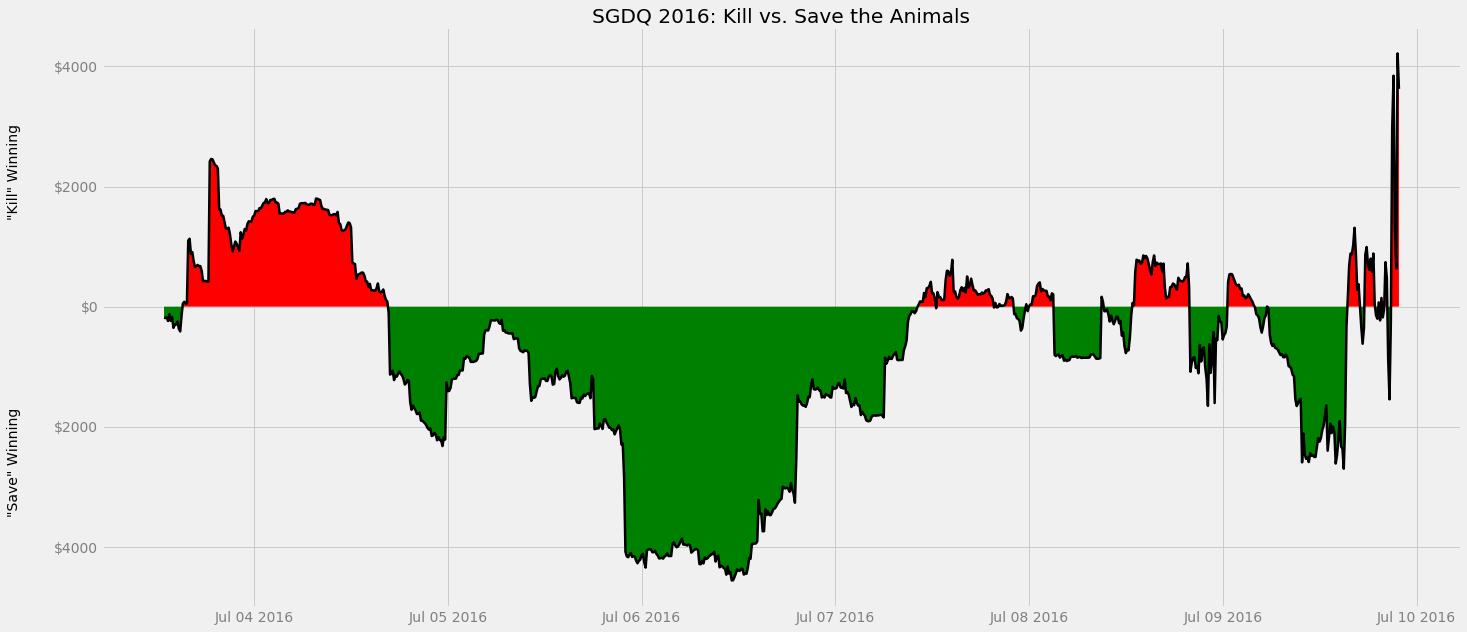

In [3]:
plt.rcParams["figure.figsize"] = (20,9)
fig, ax = plt.subplots()
plt.plot(bid_df.index, bid_df.kill_over_save, color='black', linewidth=2.5)
plt.fill_between(bid_df.index, bid_df.kill_over_save, where=bid_df.kill_over_save_pos, facecolor='red', interpolate=True)
plt.fill_between(bid_df.index, bid_df.kill_over_save, where=bid_df.kill_over_save_pos == False, facecolor='green', interpolate=True)
plt.title("SGDQ 2016: Kill vs. Save the Animals")
plt.tight_layout()
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, y: "$" + str(abs(int(x)))))
ax.text(-.07, 0.75, '"Kill" Winning',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes,
     rotation=90)
ax.text(-.07, 0.25, '"Save" Winning',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes,
     rotation=90)
plt.savefig('./after/img/kill_vs_save.png', bbox_inches='tight', dpi=100)
plt.savefig('./after/render/kill_vs_save.png', bbox_inches='tight', dpi=500)


2016-07-09 19:00:00


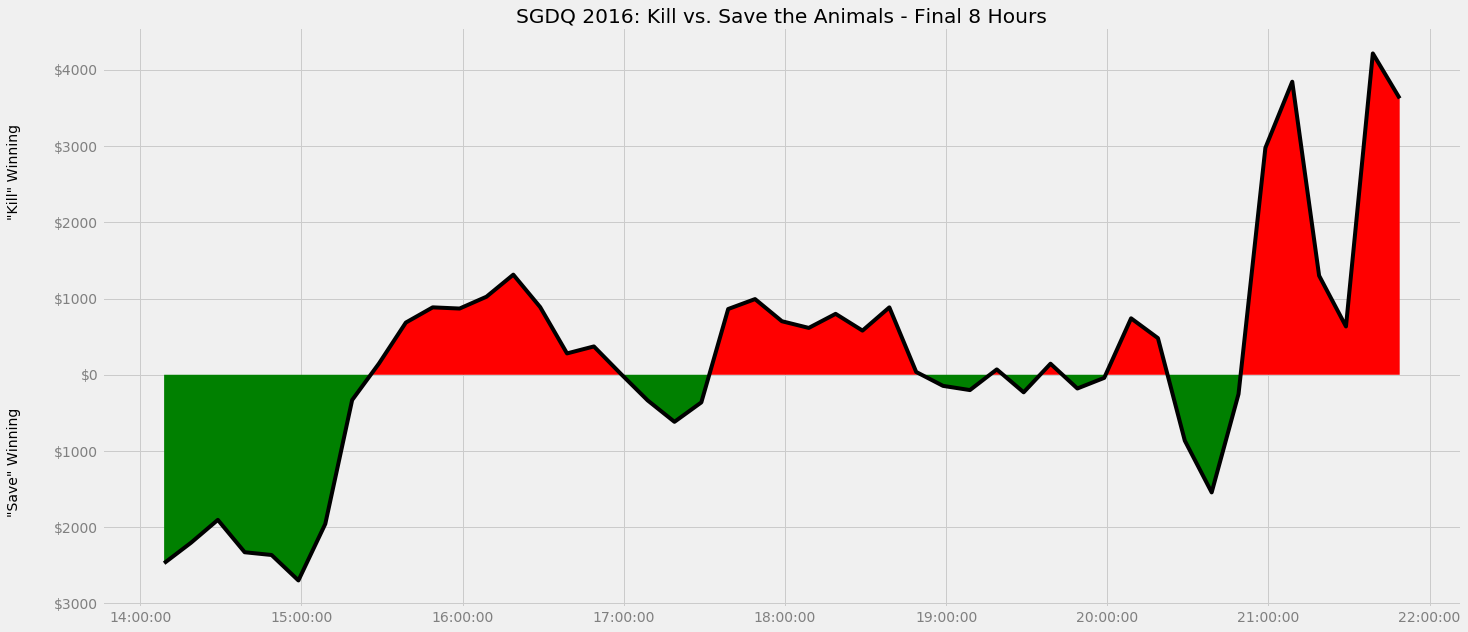

In [4]:
start_time = pd.to_datetime(1468090800, unit='s')
print start_time
bid_df_sliced = bid_df[bid_df.index > start_time]
plt.rcParams["figure.figsize"] = (20,9)
fig, ax = plt.subplots()
plt.plot(bid_df_sliced.index, bid_df_sliced.kill_over_save, color='black')
plt.fill_between(bid_df_sliced.index, bid_df_sliced.kill_over_save, where=bid_df_sliced.kill_over_save_pos, facecolor='red', interpolate=True)
plt.fill_between(bid_df_sliced.index, bid_df_sliced.kill_over_save, where=bid_df_sliced.kill_over_save_pos == False, facecolor='green', interpolate=True)
plt.title("SGDQ 2016: Kill vs. Save the Animals - Final 8 Hours")
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, y: "$" + str(abs(int(x)))))
ax.text(-.07, 0.75, '"Kill" Winning',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes,
     rotation=90)
ax.text(-.07, 0.25, '"Save" Winning',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes,
     rotation=90)
plt.tight_layout()
plt.savefig('./after/img/kill_vs_save_last_8.png', bbox_inches='tight', dpi=100)
plt.savefig('./after/render/kill_vs_save_last_8.png', bbox_inches='tight', dpi=500)

## Max Viewers

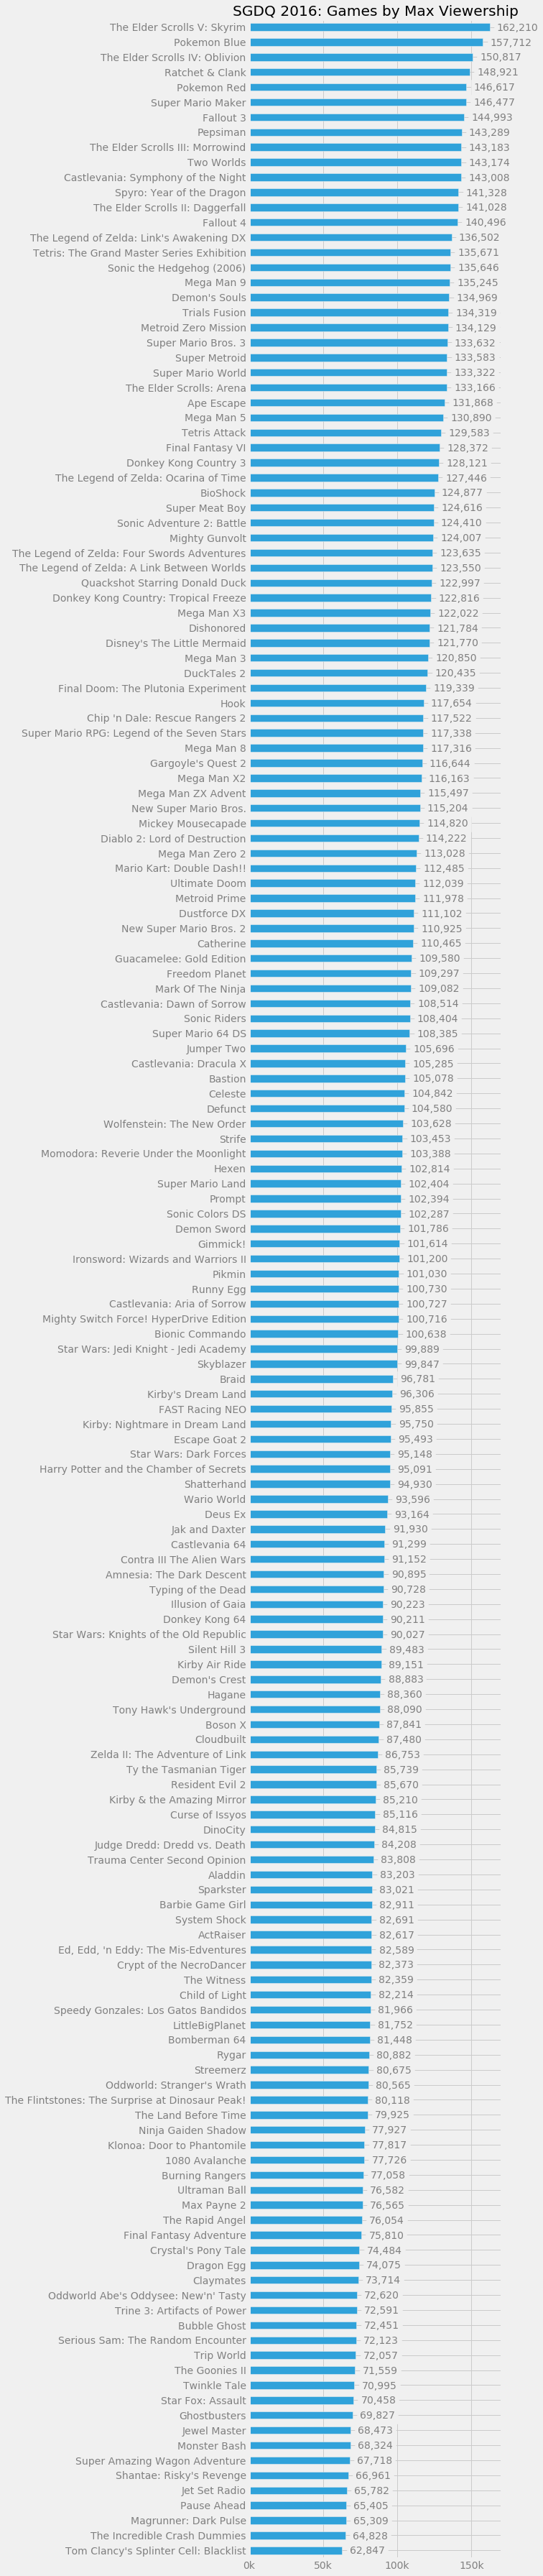

In [5]:
max_v_df =  graph_df.groupby(['game'])['v'].max()
max_v_df = max_v_df.sort_values(ascending=True)
ax = max_v_df.plot(kind='barh', figsize=(10,50), color="#30A2DA")
for idx, x in enumerate(max_v_df):
    ax.annotate('{:,}'.format(int(x)),
                (x + 5000, idx),
                xytext=(0, -5), 
                textcoords='offset points',
                color='grey',
                backgroundcolor='#F0F0F0')
plt.title("SGDQ 2016: Games by Max Viewership")
ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, y: str(int(abs(x) / 1000)) + 'k'))
plt.ylabel('')
plt.tight_layout()
plt.savefig('./after/img/games_by_viewers.png', bbox_inches='tight', dpi=100)
plt.savefig('./after/render/games_by_viewers.png', bbox_inches='tight', dpi=500)

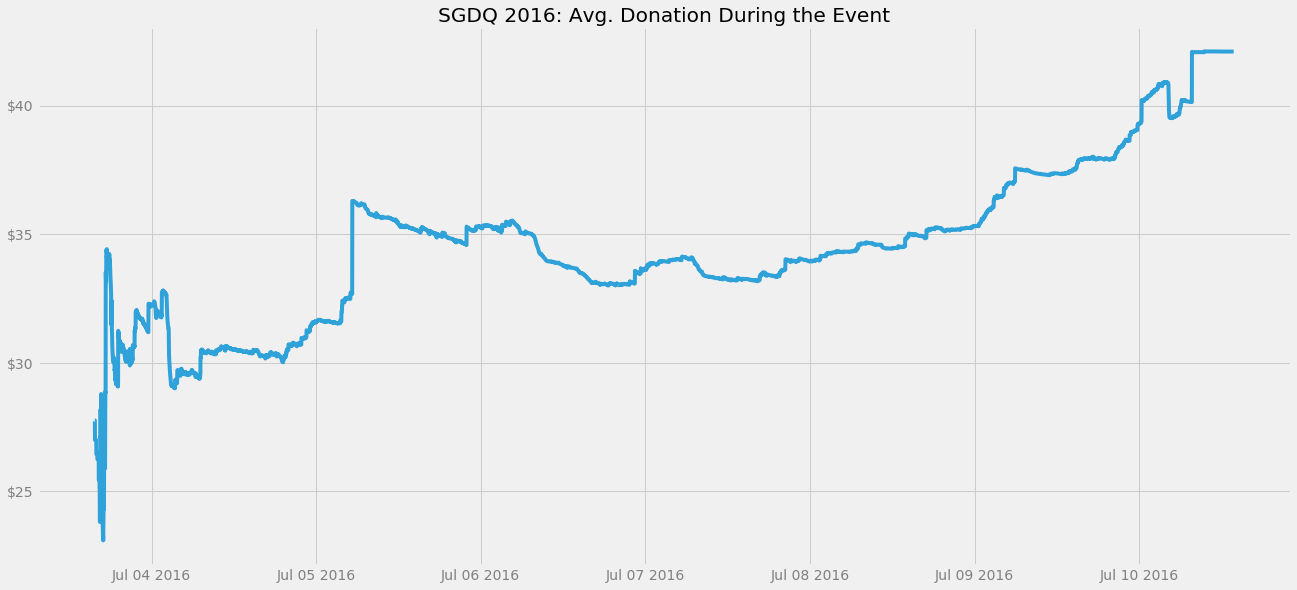

In [6]:
fig, ax = plt.subplots()
plt.plot(graph_df.avg_don)
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, y: "$" + str(int(x))))
plt.title("SGDQ 2016: Avg. Donation During the Event")
plt.savefig('./after/img/avg_donation_thru_event.png', bbox_inches='tight', dpi=100)
plt.savefig('./after/render/avg_donation_thru_event.png', bbox_inches='tight', dpi=500)

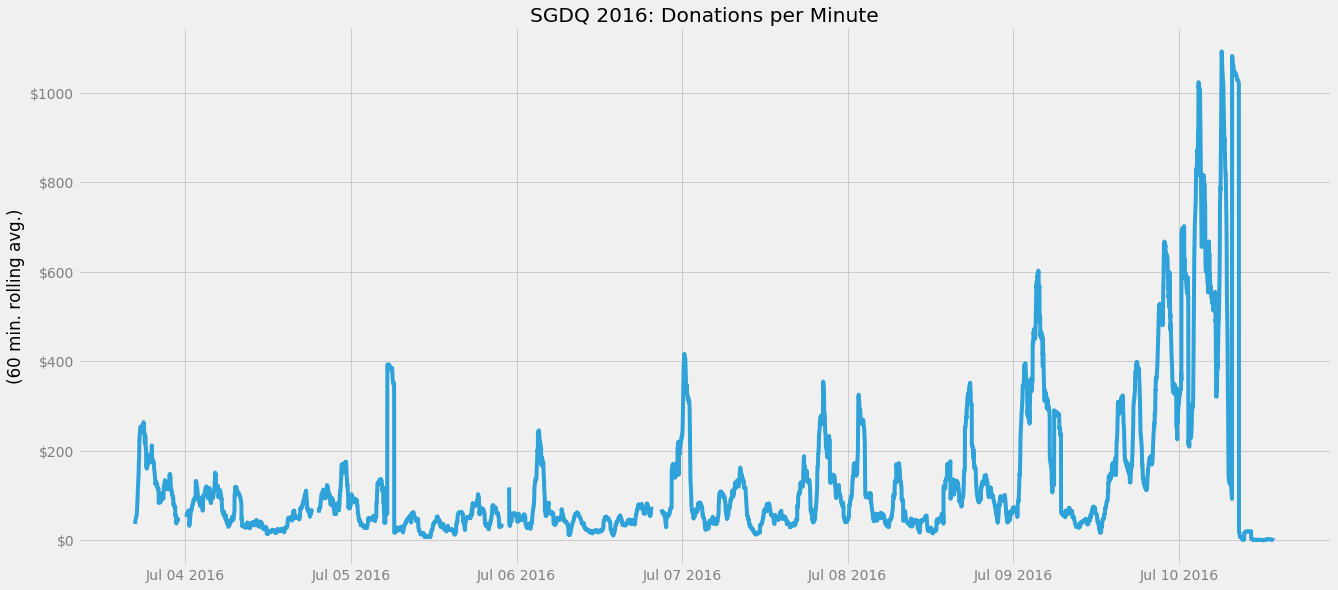

In [7]:
rolling_mean = pd.rolling_mean(graph_df.m_per_min, 60)
fig, ax = plt.subplots()
plt.plot(rolling_mean)
plt.ylabel('(60 min. rolling avg.)')
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, y: "$" + str(int(x))))
plt.title("SGDQ 2016: Donations per Minute")
plt.savefig('./after/img/donations_per_minute_thru_event.png', bbox_inches='tight', dpi=100)
plt.savefig('./after/render/donations_per_minute_thru_event.png', bbox_inches='tight', dpi=500)

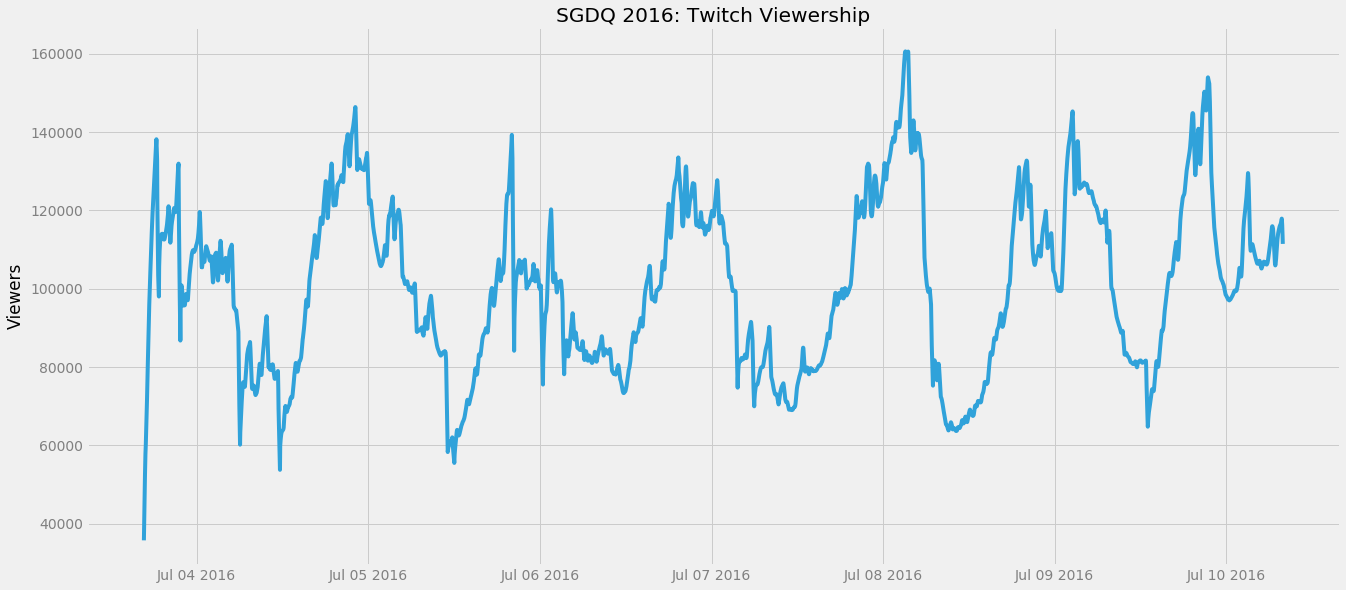

In [8]:
cleaned = pd.rolling_mean(graph_df.v[graph_df.v > 0], 15)
plt.plot(cleaned)
plt.ylabel("Viewers")
plt.title("SGDQ 2016: Twitch Viewership")
plt.savefig('./after/img/twitch_viewers_thru_event.png', bbox_inches='tight', dpi=100)
plt.savefig('./after/render/twitch_viewers_thru_event.png', bbox_inches='tight', dpi=500)

In [9]:
most_emoted_games = graph_df.groupby('game').e.mean().sort_values(ascending=False)


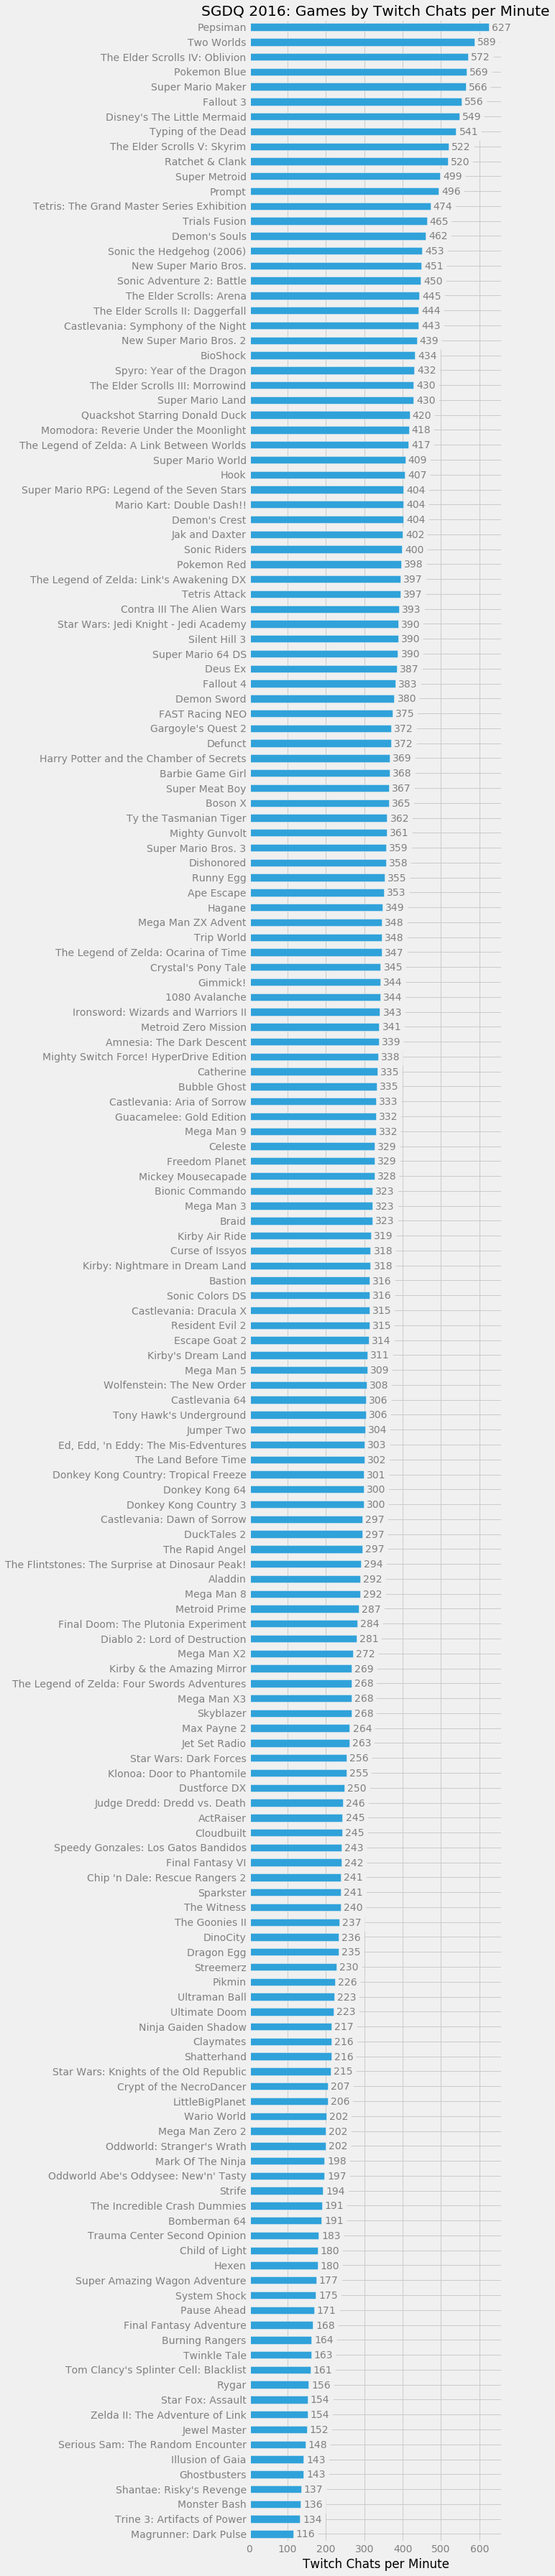

In [16]:
most_chatty_games = graph_df.groupby('game').c.mean().sort_values(ascending=True)
ax = most_chatty_games.plot(kind='barh', figsize=(10,50), color="#30A2DA")
for idx, x in enumerate(most_chatty_games):
    ax.annotate('{:,}'.format(int(x)),
                (x + 5, idx),
                xytext=(0, -5), 
                textcoords='offset points',
                color='grey',
                backgroundcolor='#F0F0F0')
plt.title("SGDQ 2016: Games by Twitch Chats per Minute")
plt.ylabel('')
plt.xlabel('Twitch Chats per Minute')
plt.tight_layout()
plt.savefig('./after/img/games_by_twitch_chats.png', bbox_inches='tight', dpi=100)
plt.savefig('./after/render/games_by_twitch_chats.png', bbox_inches='tight', dpi=500)

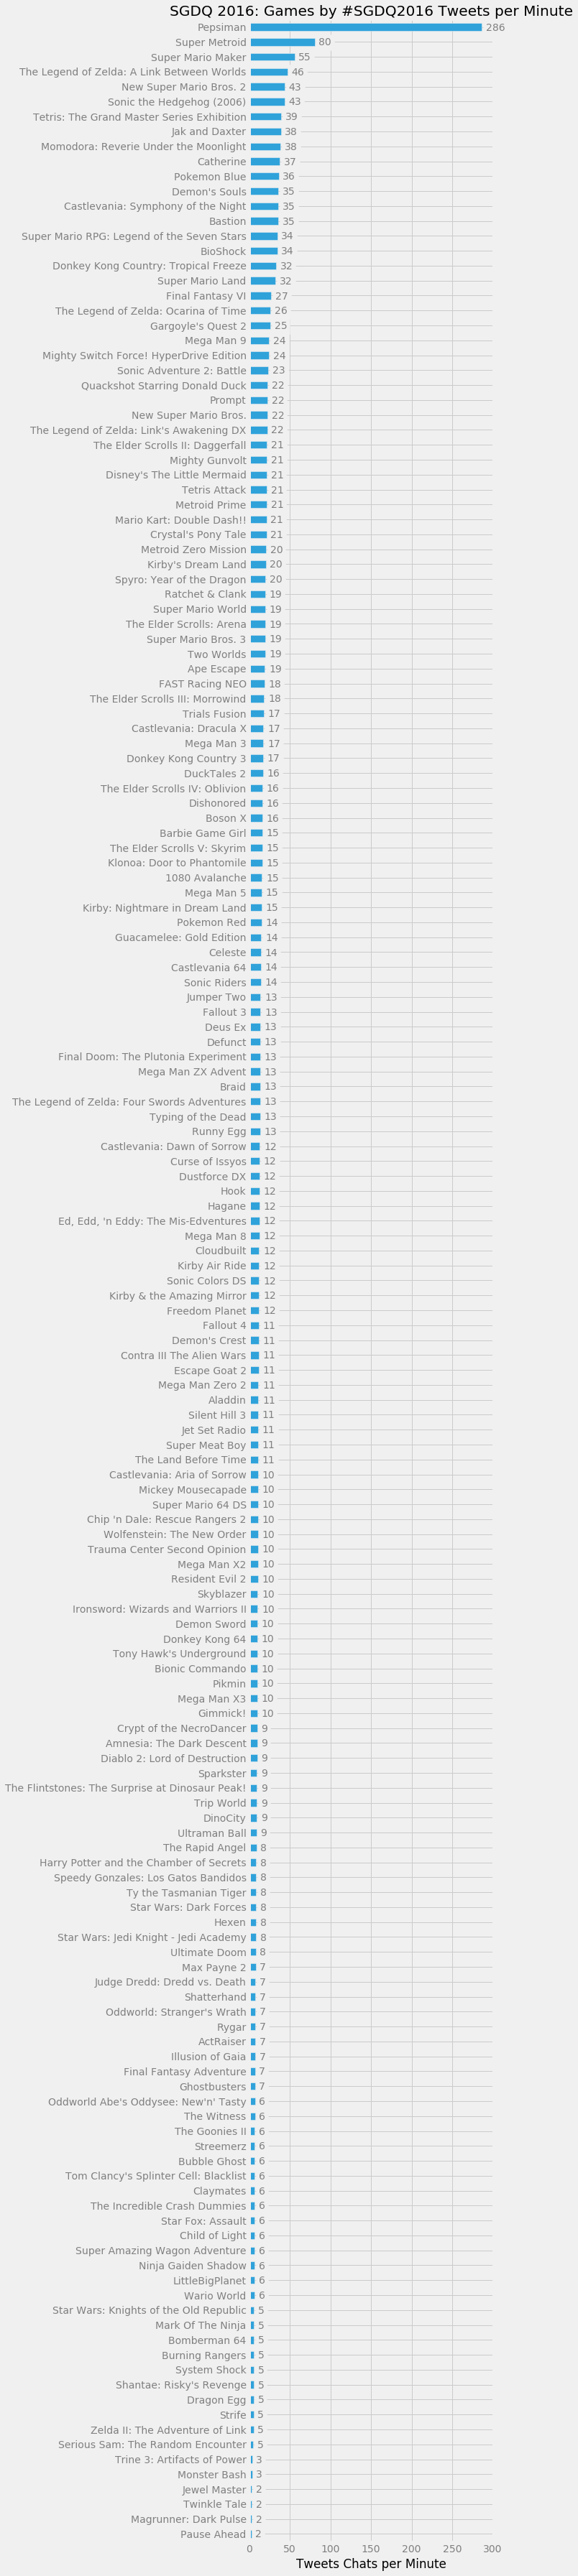

In [17]:
most_tweeted_games = graph_df.groupby('game').t.mean().sort_values(ascending=True)

ax = most_tweeted_games.plot(kind='barh', figsize=(10,50), color="#30A2DA")
for idx, x in enumerate(most_tweeted_games):
    ax.annotate('{:,}'.format(int(x)),
                (x + 5, idx),
                xytext=(0, -5), 
                textcoords='offset points',
                color='grey',
                backgroundcolor='#F0F0F0')
plt.title("SGDQ 2016: Games by #SGDQ2016 Tweets per Minute")
plt.ylabel('')
plt.xlabel('Tweets Chats per Minute')
plt.tight_layout()
plt.savefig('./after/img/games_by_tweets.png', bbox_inches='tight', dpi=100)
plt.savefig('./after/render/games_by_tweets.png', bbox_inches='tight', dpi=500)

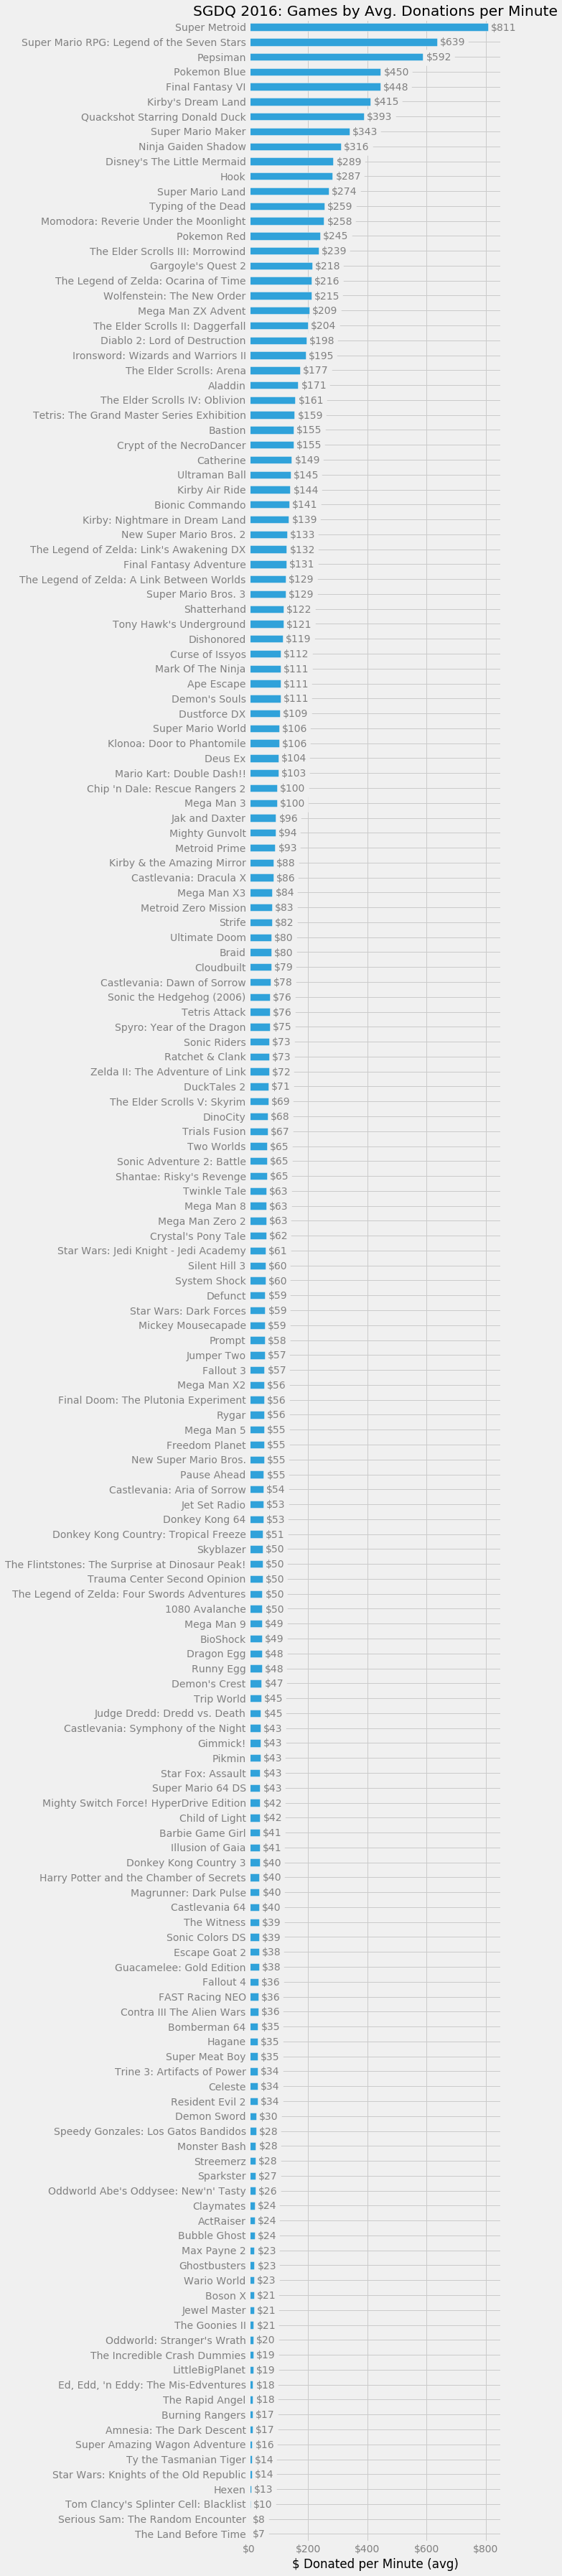

In [12]:
donations_per_min = graph_df.groupby('game').m_per_min.mean().sort_values(ascending=True)
ax = donations_per_min.plot(kind='barh', figsize=(10,50), color="#30A2DA")
for idx, x in enumerate(donations_per_min):
    ax.annotate('${:,}'.format(int(x)),
                (x + 5, idx),
                xytext=(0, -5), 
                textcoords='offset points',
                color='grey',
                backgroundcolor='#F0F0F0')
plt.title("SGDQ 2016: Games by Avg. Donations per Minute")
plt.ylabel('')
plt.xlabel('$ Donated per Minute (avg)')
ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, y: "$" + str(int(abs(x)))))

plt.tight_layout()
plt.show()
plt.savefig('./after/img/games_by_donations_per_minute.png', bbox_inches='tight', dpi=100)
plt.savefig('./after/render/games_by_donations_per_minute.png', bbox_inches='tight', dpi=500)

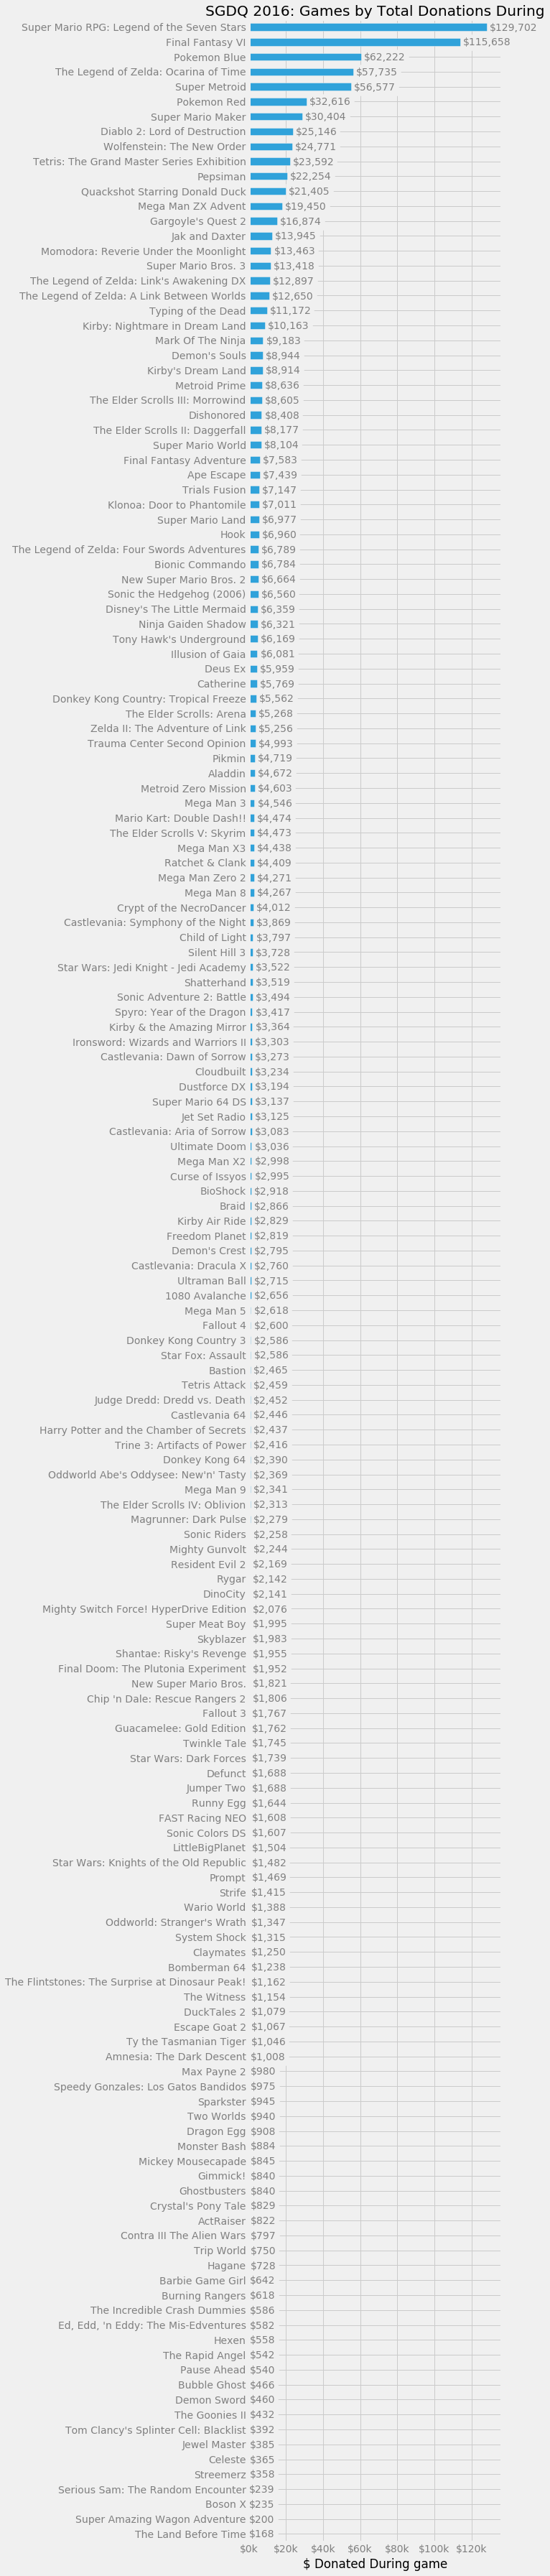

In [13]:
donations_during = graph_df.groupby('game').m.max() - graph_df.groupby('game').m.min()
donations_during = donations_during.sort_values(ascending=True)
ax = donations_during.plot(kind='barh', figsize=(10,50), color="#30A2DA")
for idx, x in enumerate(donations_during):
    ax.annotate('${:,}'.format(int(x)),
                (x + 5, idx),
                xytext=(0, -5), 
                textcoords='offset points',
                color='grey',
                backgroundcolor='#F0F0F0')
plt.title("SGDQ 2016: Games by Total Donations During")
plt.ylabel('')
plt.xlabel('$ Donated During game')
ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, y: "$" + str(int(abs(x) / 1000)) + 'k'))
plt.tight_layout()
plt.show()